# AI-Based Medical Diagnostics: Pneumonia Detection
This notebook builds a CNN-based classifier to detect pneumonia from chest X-ray images using the dataset by Paul Mooney from Kaggle. It aligns with the original project proposal for medical imaging.

# What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**

In [ ]:
!pip install -q torch torchvision timm scikit-learn matplotlib kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.1 MB/s eta 0:00:00


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import kagglehub
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

##  Download Chest X-ray Dataset
This step downloads the chest X-ray pneumonia dataset directly from Kaggle via kagglehub.

# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [2]:
# Download dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset path:", path)

# Define dataset directories
train_dir = os.path.join(path, 'chest_xray/train')
val_dir = os.path.join(path, 'chest_xray/val')
test_dir = os.path.join(path, 'chest_xray/test')

Dataset path: /kaggle/input/chest-xray-pneumonia


**Previewing the images of both the classes**

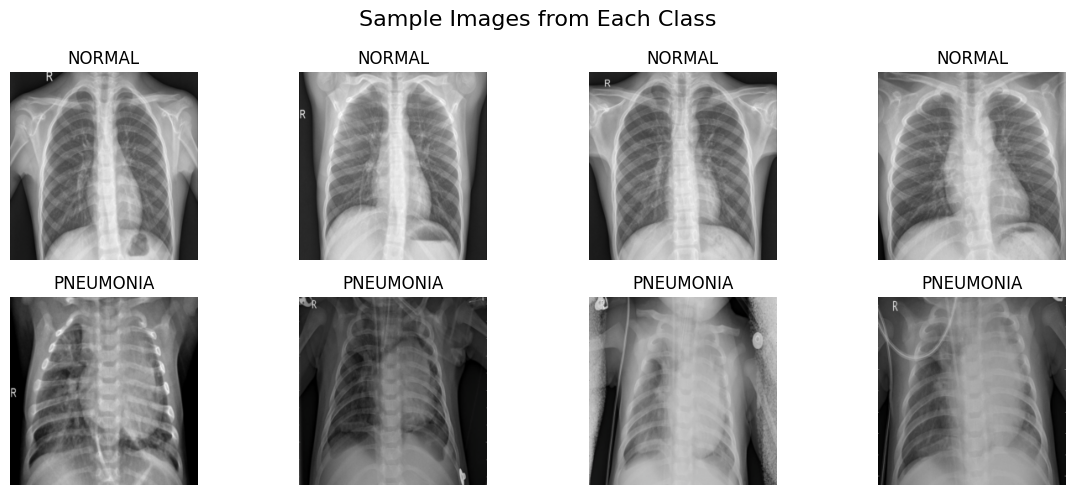

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Preview N samples from each class
num_samples_per_class = 4
class_indices = {class_name: [] for class_name in class_names}

# Collect indices for each class
for idx, (img, label) in enumerate(test_dataset):
    label_name = class_names[label]
    if len(class_indices[label_name]) < num_samples_per_class:
        class_indices[label_name].append(idx)
    if all(len(indices) == num_samples_per_class for indices in class_indices.values()):
        break

# Plot
plt.figure(figsize=(12, 5))

for i, class_name in enumerate(class_names):
    for j, idx in enumerate(class_indices[class_name]):
        image, _ = test_dataset[idx]
        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        plt.subplot(2, num_samples_per_class, i * num_samples_per_class + j + 1)
        plt.imshow(img_np)
        plt.title(class_name)
        plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


##  Data Preprocessing
We normalize and augment training images to reduce overfitting.

In [3]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

datasets = {
    'train': datasets.ImageFolder(train_dir, transform['train']),
    'val': datasets.ImageFolder(val_dir, transform['val'])
}
dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=32, shuffle=True),
    'val': DataLoader(datasets['val'], batch_size=32)
}
class_names = datasets['train'].classes

## Model Setup: ResNet18 with Transfer Learning

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 208MB/s]


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    return model

In [ ]:
trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

Epoch 1/5


100%|██████████| 163/163 [02:12<00:00,  1.23it/s]


train Loss: 0.1062 Acc: 0.9553


100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


val Loss: 0.2936 Acc: 0.8125
Epoch 2/5


100%|██████████| 163/163 [01:38<00:00,  1.65it/s]


train Loss: 0.0456 Acc: 0.9835


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


val Loss: 0.1184 Acc: 0.9375
Epoch 3/5


100%|██████████| 163/163 [01:39<00:00,  1.64it/s]


train Loss: 0.0200 Acc: 0.9935


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


val Loss: 0.3156 Acc: 0.8750
Epoch 4/5


100%|██████████| 163/163 [01:37<00:00,  1.66it/s]


train Loss: 0.0139 Acc: 0.9952


100%|██████████| 1/1 [00:00<00:00,  4.06it/s]


val Loss: 0.7128 Acc: 0.7500
Epoch 5/5


100%|██████████| 163/163 [01:39<00:00,  1.63it/s]


train Loss: 0.0175 Acc: 0.9944


100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

val Loss: 0.0371 Acc: 1.0000


In [ ]:
# 11. Save the trained model
torch.save(trained_model.state_dict(), "resnet18_pneumonia.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



✅ Test Accuracy: 0.8558

📊 Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.64      0.77       234
   PNEUMONIA       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.87      0.86      0.85       624



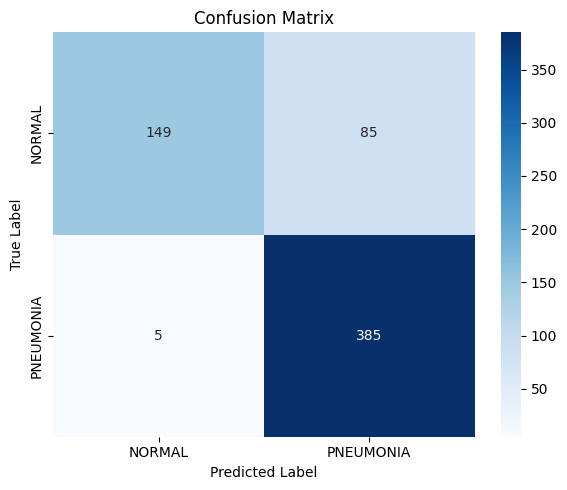

In [ ]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Automatically fetch the path from kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
test_dir = os.path.join(path, 'chest_xray/test')

class_names = ['NORMAL', 'PNEUMONIA']

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load("resnet18_pneumonia.pth", map_location=device))
model = model.to(device)
model.eval()

# Prediction & Evaluation
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {accuracy:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


##  Evaluation

In [ ]:
model.eval()
all_preds = []
all_labels = []
for inputs, labels in tqdm(dataloaders['val']):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
print(classification_report(all_labels, all_preds, target_names=class_names))

100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



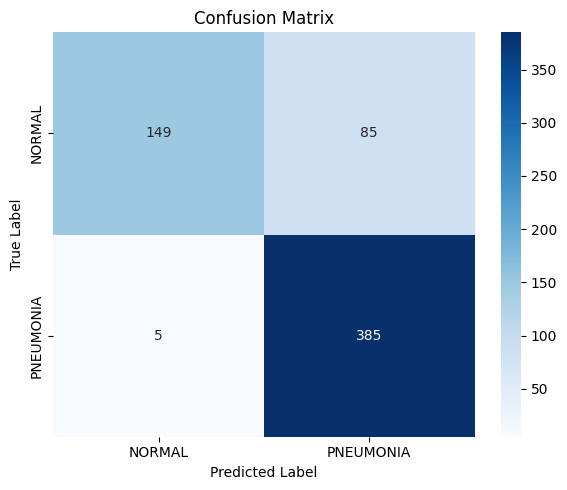

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class names (adjust if needed)
class_names = ['NORMAL', 'PNEUMONIA']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
import numpy as np

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Get indices of correct predictions
correct = np.nonzero(y_pred == y_true)[0]

# Get indices of incorrect predictions
incorrect = np.nonzero(y_pred != y_true)[0]

print(f"✅ Correct Predictions: {len(correct)}")
print(f"❌ Incorrect Predictions: {len(incorrect)}")


✅ Correct Predictions: 534
❌ Incorrect Predictions: 90


**Some of the Correctly Predicted Classes**

<ipython-input-17-39b3f02bbd9a>:17: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


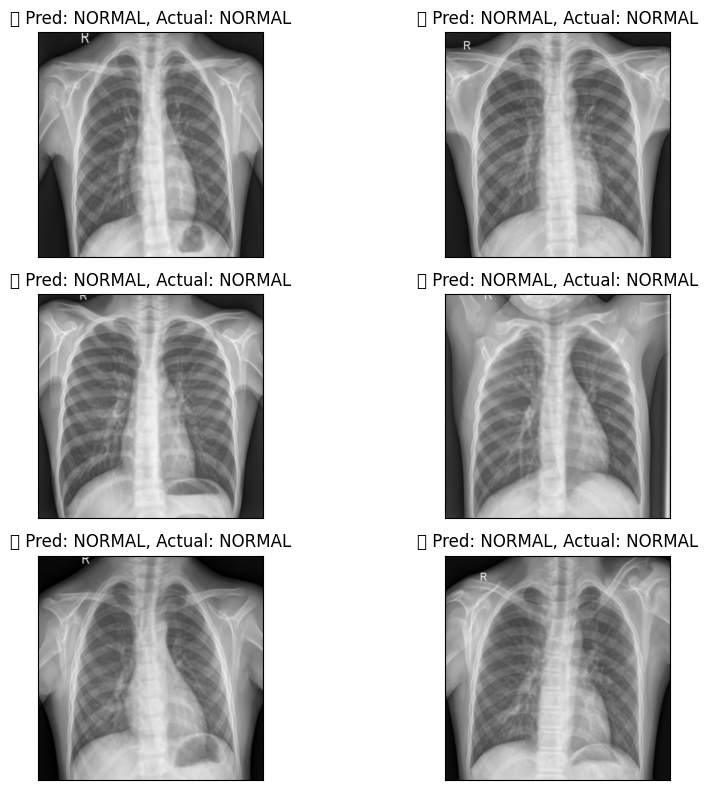

In [ ]:
i = 0
plt.figure(figsize=(10, 8))

for c in correct[:6]:
    image, _ = test_dataset[c]  # get image by index from test_dataset
    img_np = image.permute(1, 2, 0).cpu().numpy()  # convert CHW → HWC
    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # unnormalize
    img_np = np.clip(img_np, 0, 1)  # clip to valid range

    plt.subplot(3, 2, i + 1)
    plt.imshow(img_np)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"✅ Pred: {class_names[y_pred[c]]}, Actual: {class_names[y_true[c]]}")
    i += 1

plt.tight_layout()
plt.show()


**Some of the Incorrectly Predicted Classes**

<ipython-input-18-4a6b0d6f800c>:22: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


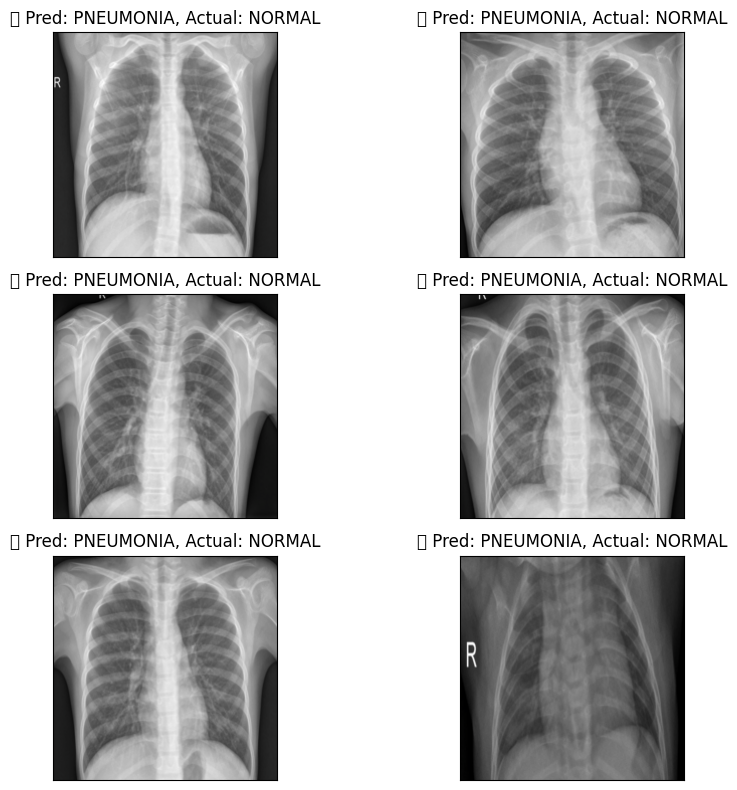

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

i = 0
plt.figure(figsize=(10, 8))

for idx in incorrect[:6]:
    image, _ = test_dataset[idx]  # Get image from dataset
    img_np = image.permute(1, 2, 0).cpu().numpy()  # CHW → HWC for plotting

    # Unnormalize image
    img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    plt.subplot(3, 2, i + 1)
    plt.imshow(img_np)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"❌ Pred: {class_names[y_pred[idx]]}, Actual: {class_names[y_true[idx]]}")
    i += 1

plt.tight_layout()
plt.show()


## Grad-CAM for Explainability
Grad-CAM helps visualize which parts of the image were most important for the model's prediction.

In [ ]:
from torchvision.transforms.functional import to_pil_image
import numpy as np

In [ ]:
def generate_gradcam(model, input_tensor, target_layer):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_backward_hook(backward_hook)

    # Forward + backward
    output = model(input_tensor)
    class_idx = torch.argmax(output).item()
    model.zero_grad()
    output[0, class_idx].backward()

    grad = gradients[0].squeeze(0).cpu().detach()
    act = activations[0].squeeze(0).cpu().detach()

    weights = grad.mean(dim=(1, 2))
    cam = torch.zeros(act.shape[1:], dtype=torch.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]
    cam = np.maximum(cam.detach().numpy(), 0)
    cam = cam / cam.max()
    cam = np.uint8(255 * cam)

    handle_fw.remove()
    handle_bw.remove()

    return cam, class_idx


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


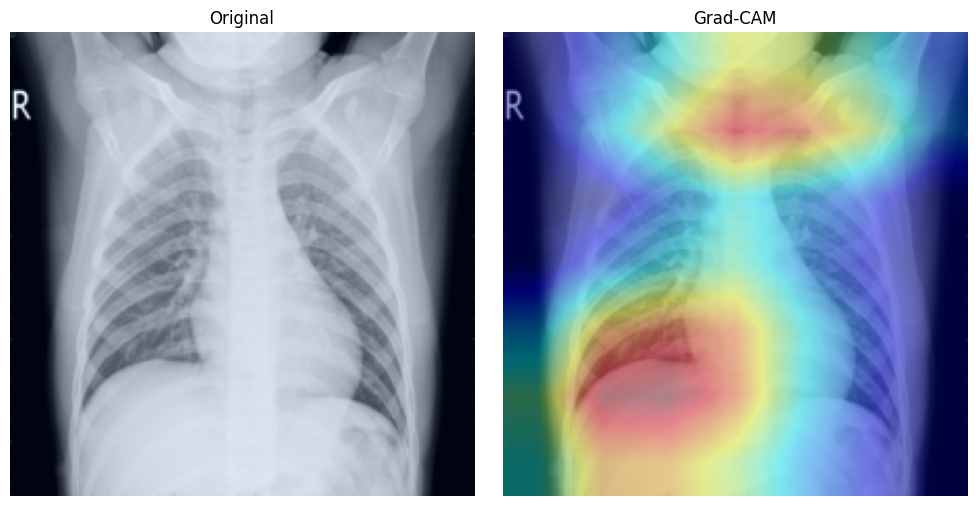

In [ ]:
# Example usage on a single image from the validation set
dataiter = iter(dataloaders['val'])
images, labels = next(dataiter)
input_img = images[0].unsqueeze(0).to(device)

# Choose last convolutional layer of ResNet
target_layer = model.layer4[1].conv2
cam, predicted_class = generate_gradcam(model, input_img, target_layer)

# Display image and Grad-CAM overlay
import cv2
import matplotlib.pyplot as plt

img_np = images[0].permute(1, 2, 0).cpu().numpy()
img_np = (img_np * 0.229 + 0.485)  # Unnormalize
img_np = np.clip(img_np, 0, 1)

# Resize CAM to match image
cam = cv2.resize(cam, (224, 224))

# Create heatmap and overlay
heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
overlay = 0.4 * heatmap / 255 + 0.6 * img_np  # Blend

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlay)
plt.axis('off')

plt.tight_layout()
plt.show()

CNN Base Model

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import kagglehub



# === Step 2: Image Data Generators ===
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# === Step 3: Build CNN Model ===
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# === Step 4: Callbacks ===
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=1e-6)




Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 38, 38, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,666,817 (13.99 MB)

 Trainable params: 3,665,857 (13.98 MB)

 Non-trainable params: 960 (3.75 KB)

In [5]:
# === Step 5: Training ===
history = model.fit(
    train_gen,
    epochs=12,
    validation_data=val_gen,
    callbacks=[lr_reduction]
)

# === Step 6: Evaluation ===
loss, accuracy = model.evaluate(test_gen)
print("Loss of the model is -", loss)
print("Accuracy of the model is -", accuracy * 100, "%")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 387ms/step - accuracy: 0.8804 - loss: 0.4055 - val_accuracy: 0.5000 - val_loss: 5.1676 - learning_rate: 1.0000e-04
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 199ms/step - accuracy: 0.9651 - loss: 0.0870 - val_accuracy: 0.5000 - val_loss: 8.5220 - learning_rate: 1.0000e-04
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9746 - loss: 0.0675
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 198ms/step - accuracy: 0.9745 - loss: 0.0675 - val_accuracy: 0.5000 - val_loss: 5.3454 - learning_rate: 1.0000e-04
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 198ms/step - accuracy: 0.9864 - loss: 0.0394 - val_accuracy: 0.5625 - val_loss: 1.7328 - learning_rate: 3.0000e-05
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.9907 - loss: 0.0273 - val_accuracy: 0.6875 - val_loss: 0.8115 - learning_rate: 3.0000e-05
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 195ms/s

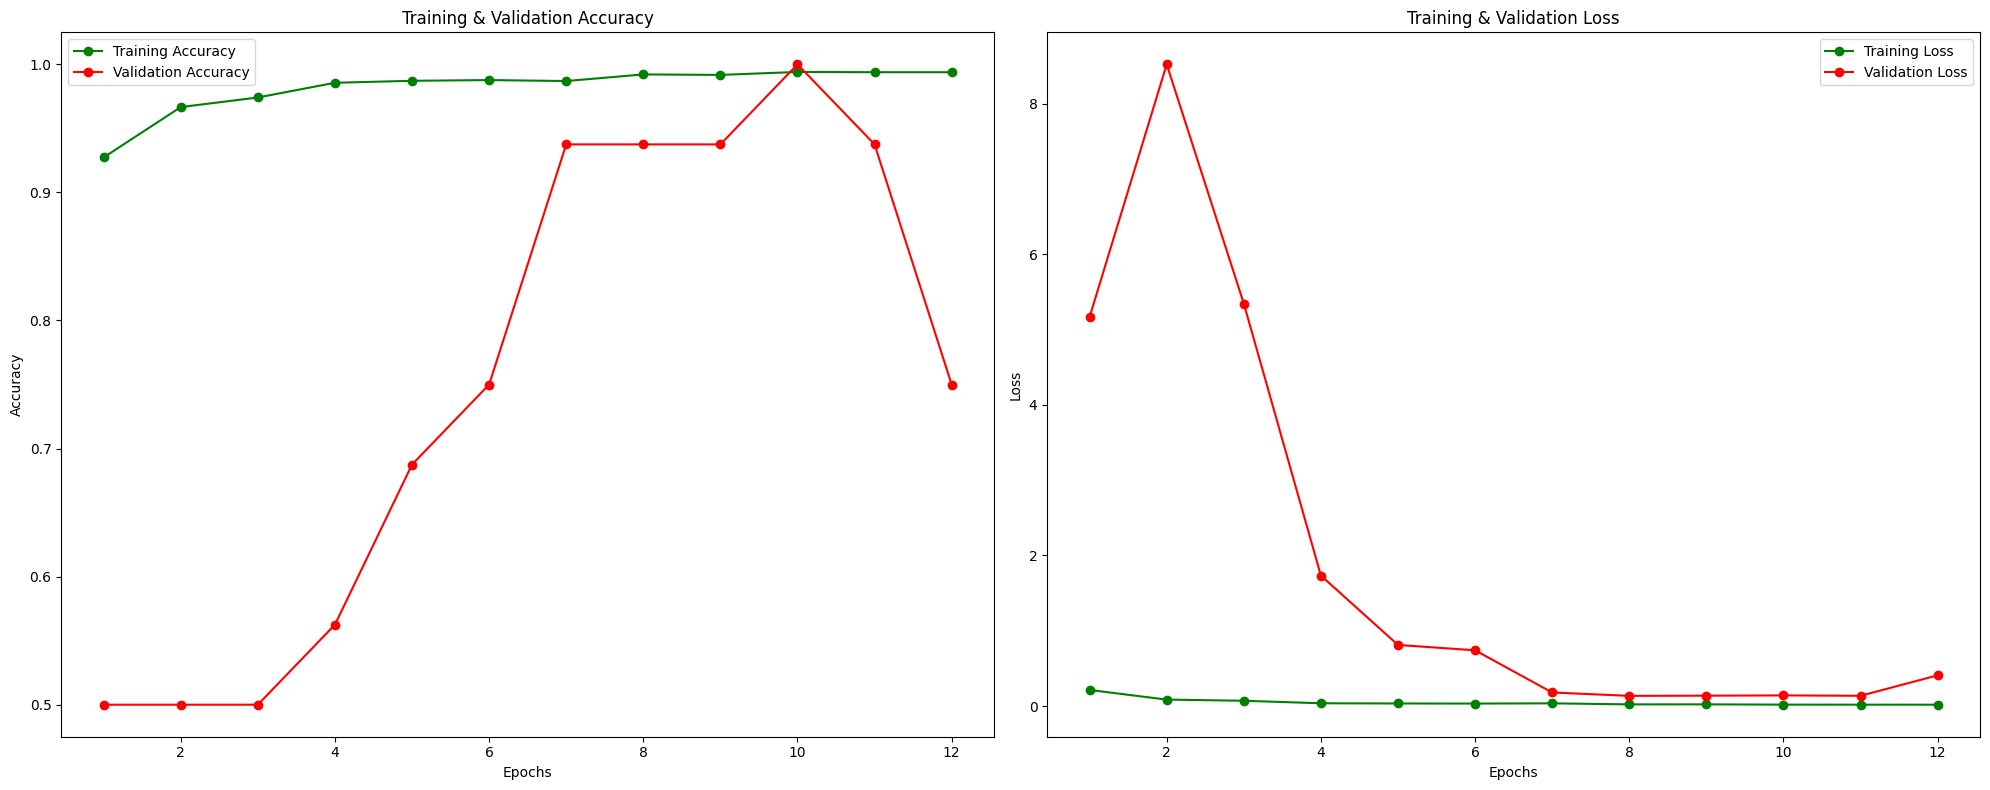

In [6]:
# === Step 7: Plot Accuracy & Loss ===
epochs_range = range(1, 13)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

ax[0].plot(epochs_range, train_acc, 'go-', label='Training Accuracy')
ax[0].plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(epochs_range, train_loss, 'g-o', label='Training Loss')
ax[1].plot(epochs_range, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()



20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step

Classification Report:
              precision    recall  f1-score   support

   Pneumonia       1.00      0.29      0.45       234
      Normal       0.70      1.00      0.82       390

    accuracy                           0.73       624
   macro avg       0.85      0.64      0.63       624
weighted avg       0.81      0.73      0.68       624



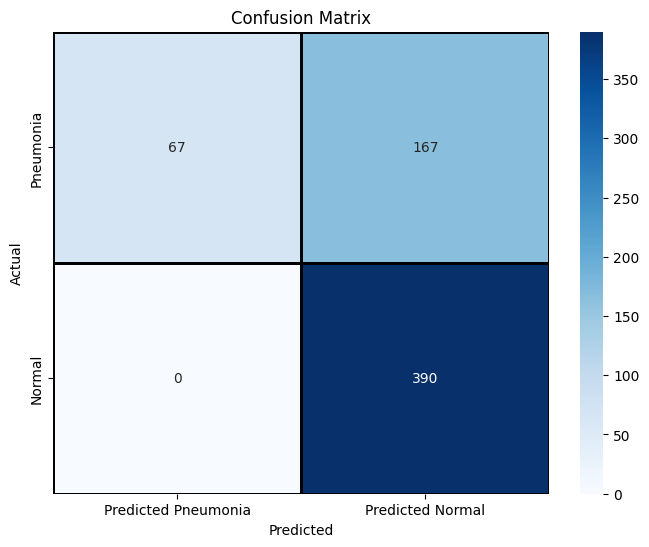

In [8]:
# === Step 8: Predictions & Confusion Matrix ===
y_pred = (model.predict(test_gen) > 0.5).astype(int).reshape(-1)
y_true = test_gen.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Pneumonia', 'Normal']))

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=['Pneumonia', 'Normal'], columns=['Predicted Pneumonia', 'Predicted Normal'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='d', linewidths=1, linecolor='black')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



In [10]:
# === Step 9: Display Correct & Incorrect Predictions ===
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

print(f"✅ Correct Predictions: {len(correct)}")
print(f"❌ Incorrect Predictions: {len(incorrect)}")

✅ Correct Predictions: 457
❌ Incorrect Predictions: 167


<ipython-input-11-d2e8dc280105>:12: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


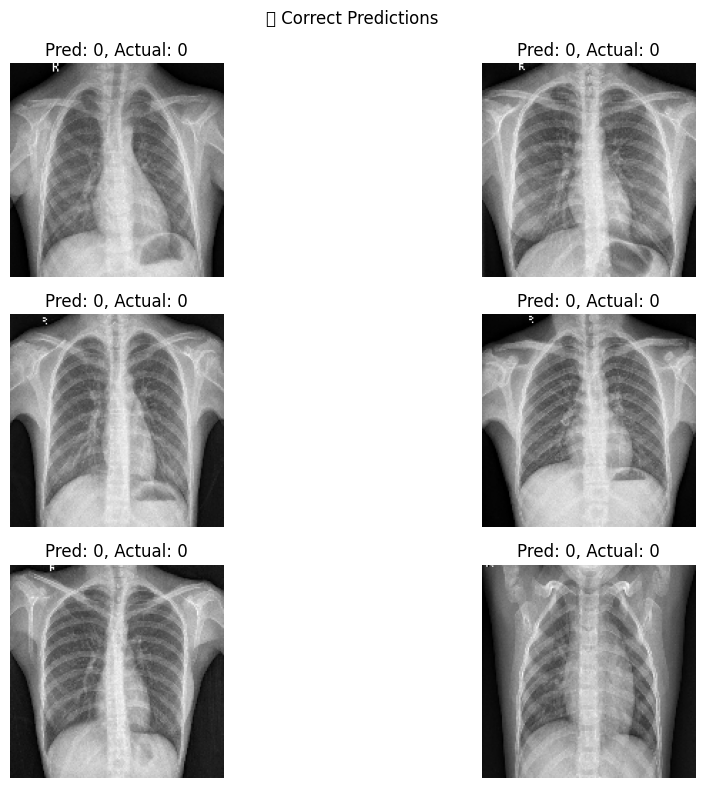

<ipython-input-11-d2e8dc280105>:12: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


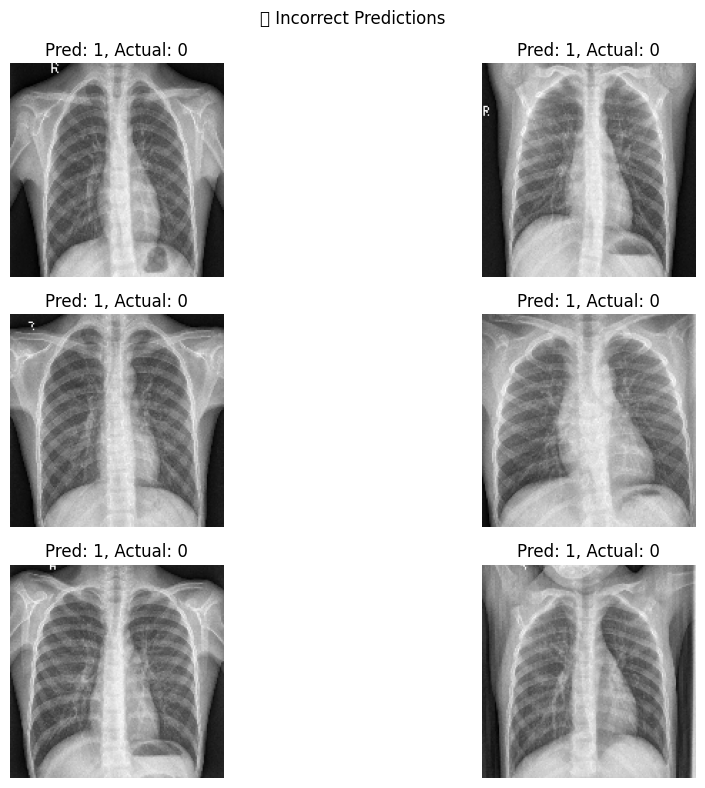

In [11]:


# Load images manually for visualization
img_paths = test_gen.filepaths
def show_images(indices, title):
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(indices[:6]):
        img = tf.keras.utils.load_img(img_paths[idx], color_mode='grayscale', target_size=(150, 150))
        plt.subplot(3, 2, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Pred: {int(y_pred[idx])}, Actual: {y_true[idx]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(correct, "✅ Correct Predictions")
show_images(incorrect, "❌ Incorrect Predictions")

GAN


In [20]:
import os
from PIL import Image
import kagglehub

# Download dataset if not already
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
pneumonia_dir = os.path.join(path, "chest_xray/train/PNEUMONIA")

# Print size of first few images
print("Sample image sizes from PNEUMONIA folder:\n")
for i, file in enumerate(os.listdir(pneumonia_dir)):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(pneumonia_dir, file)
        with Image.open(img_path) as img:
            print(f"{file} --> size: {img.size}")  # (width, height)
        if i >= 4:
            break


Sample image sizes from PNEUMONIA folder:

person1180_virus_2010.jpeg --> size: (1024, 712)
person1230_virus_2081.jpeg --> size: (1424, 1016)
person1513_virus_2632.jpeg --> size: (1376, 1208)
person124_virus_238.jpeg --> size: (1336, 1256)
person746_virus_1369.jpeg --> size: (895, 516)


In [ ]:
"""
Simple DCGAN for 128×128 grayscale chest‑X‑ray images
Dataset: “paultimothymooney/chest‑xray‑pneumonia” (KaggleHub)
Workflow:
1.  Download & load PNEUMONIA images from the train split
2.  Train a GAN for num_epochs
3.  Visualize 16 generated images after training
"""

# ---------- 1. Imports ----------
import os, matplotlib.pyplot as plt, numpy as np, torch, torch.nn as nn
import torch.optim as optim, torchvision.utils as vutils, torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import kagglehub

# ---------- 2. Hyper‑parameters ----------
image_size   = 128          # square output 128×128
nc           = 1            # number of channels (grayscale)
nz           = 100          # latent‑vector (noise) length
ngf, ndf     = 64, 64       # feature‑map sizes
batch_size   = 32
num_epochs   = 20
lr, beta1    = 0.0002, 0.5  # Adam
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 3. Dataset ----------
root_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
train_dir = os.path.join(root_path, "chest_xray/train")           # full train folder
pneu_only = os.path.join(train_dir, "PNEUMONIA")                  # pneumonia images

transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

full_train = ImageFolder(train_dir, transform=transform)
# keep only pneumonia samples
full_train.samples = [s for s in full_train.samples if "PNEUMONIA" in s[0]]
dloader = DataLoader(full_train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [22]:


# ---------- 4. Generator ----------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),      # 4×4
            nn.BatchNorm2d(ngf*8), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),   # 8×8
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),   # 16×16
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),     # 32×32
            nn.BatchNorm2d(ngf), nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 4, 0, bias=False),        # 128×128
            nn.Tanh()
        )

    def forward(self, z): return self.net(z)

# ---------- 5. Discriminator ----------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),                 # 64×64
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),              # 32×32
            nn.BatchNorm2d(ndf*2), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),            # 16×16
            nn.BatchNorm2d(ndf*4), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),            # 8×8
            nn.BatchNorm2d(ndf*8), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*8, 1, 8, 1, 0, bias=False),                # 1×1
            nn.Sigmoid()
        )

    def forward(self, x): return self.net(x).view(-1)               # shape [batch]

# ---------- 6. Instantiate ----------
netG, netD = Generator().to(device), Discriminator().to(device)
criterion   = nn.BCELoss()
optD        = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optG        = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

# ---------- 7. Training Loop ----------
real_label, fake_label = 1.0, 0.0

for epoch in range(1, num_epochs+1):
    for real, _ in dloader:
        b = real.size(0)
        real = real.to(device)

        # ---- Train D ----
        netD.zero_grad()
        lbl_real = torch.full((b,), real_label, device=device)
        out_real = netD(real)
        lossD_real = criterion(out_real, lbl_real)

        noise = torch.randn(b, nz, 1, 1, device=device)
        fake  = netG(noise)
        lbl_fake = torch.full((b,), fake_label, device=device)
        out_fake = netD(fake.detach())
        lossD_fake = criterion(out_fake, lbl_fake)

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optD.step()

        # ---- Train G ----
        netG.zero_grad()
        lbl_gen = torch.full((b,), real_label, device=device)       # want D to think fakes are real
        out_gen = netD(fake)
        lossG = criterion(out_gen, lbl_gen)
        lossG.backward()
        optG.step()

    print(f"Epoch [{epoch}/{num_epochs}]  Loss_D: {lossD:.4f}  Loss_G: {lossG:.4f}")




Epoch [1/20]  Loss_D: 0.0012  Loss_G: 8.7896
Epoch [2/20]  Loss_D: 4.4404  Loss_G: 19.3184
Epoch [3/20]  Loss_D: 0.4259  Loss_G: 2.0525
Epoch [4/20]  Loss_D: 3.0234  Loss_G: 1.1468
Epoch [5/20]  Loss_D: 0.6207  Loss_G: 5.3155
Epoch [6/20]  Loss_D: 0.9674  Loss_G: 12.3629
Epoch [7/20]  Loss_D: 0.3397  Loss_G: 3.4006
Epoch [8/20]  Loss_D: 0.2179  Loss_G: 8.8131
Epoch [9/20]  Loss_D: 0.7751  Loss_G: 2.4795
Epoch [10/20]  Loss_D: 0.8013  Loss_G: 9.6739
Epoch [11/20]  Loss_D: 0.0080  Loss_G: 6.6431
Epoch [12/20]  Loss_D: 0.0107  Loss_G: 6.9330
Epoch [13/20]  Loss_D: 0.0870  Loss_G: 4.3080
Epoch [14/20]  Loss_D: 0.0724  Loss_G: 6.2793
Epoch [15/20]  Loss_D: 0.6038  Loss_G: 4.0693
Epoch [16/20]  Loss_D: 0.0234  Loss_G: 4.6595
Epoch [17/20]  Loss_D: 1.1811  Loss_G: 10.6648
Epoch [18/20]  Loss_D: 0.6180  Loss_G: 0.6640
Epoch [19/20]  Loss_D: 1.5127  Loss_G: 4.1322
Epoch [20/20]  Loss_D: 0.0226  Loss_G: 8.1622


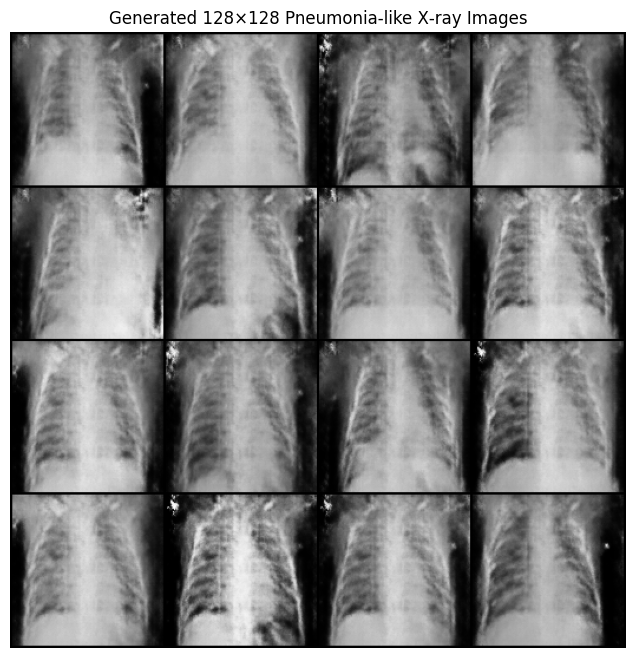

In [23]:
# ---------- 8. Generate & Visualize ----------
netG.eval()
with torch.no_grad():
    fake_imgs = netG(fixed_noise).cpu()
    fake_imgs = (fake_imgs + 1) / 2   # un‑normalize to [0,1]

plt.figure(figsize=(8,8))
grid = vutils.make_grid(fake_imgs, nrow=4, padding=2)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)), cmap='gray')
plt.axis("off")
plt.title("Generated 128×128 Pneumonia‑like X‑ray Images")
plt.show()

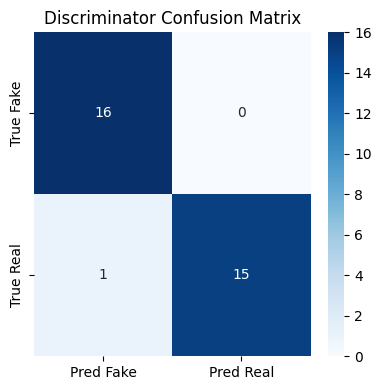

Accuracy: 0.969


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import torch.nn.functional as F

# ---------- 1. Prepare a mixed batch ----------
# 16 real + 16 fake  (you can enlarge if GPU permits)
real_batch, _ = next(iter(dloader))
real_batch = real_batch[:16].to(device)

noise       = torch.randn(16, nz, 1, 1, device=device)
fake_batch  = netG(noise).detach()

mixed_imgs  = torch.cat([real_batch, fake_batch], dim=0)
true_labels = torch.cat([
    torch.ones(16, device=device),     # real → 1
    torch.zeros(16, device=device)     # fake → 0
])

# ---------- 2. Discriminator predictions ----------
netD.eval()
with torch.no_grad():
    preds = netD(mixed_imgs)           # logits in [0,1] (Sigmoid)
pred_labels = (preds > 0.5).float()

# ---------- 3. Confusion Matrix ----------
cm = confusion_matrix(true_labels.cpu(), pred_labels.cpu())
disp = ConfusionMatrixDisplay(cm, display_labels=["Fake", "Real"])

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Pred Fake", "Pred Real"],
            yticklabels=["True Fake", "True Real"])
plt.title("Discriminator Confusion Matrix")
plt.tight_layout()
plt.show()

print(f"Accuracy: {cm.trace()/cm.sum():.3f}")
